<a href="https://colab.research.google.com/github/glingden/Natural-Language-Processing-NLP/blob/master/Bert_TextSimilarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Semantic Text Similarity

In this notebook, the BERT (bert-base-uncased) model is used for finding  semantic text similarity between the pair of sentences.  The [STS_B benchmark](https://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark) dataset is used for this work. This dataset consists of separate training, validation and test data. The work in this notebook contains two parts:
1. Sentence level embedding extraction from pre-trained the bert model and apply cosine similarity between the pair sentence (No fine-tunned/trained, but only using sentence vector representation from the pretrained model)

2. Fine-tune: The STS_B Train Dataset is used for fine tunning. And the fine-tunned model is used to  validate the validaiton dataset and predict the test dataset.

In [ ]:
#import necessary libraries
import pandas as pd
import tensorflow as tf
import torch

GPU from Google Colab is used in this work. So, check if GPU is avaiable, and if not rasie error. We have to identify and specify GPU as device in order to use it. 




In [ ]:
#check GPU is available or not 
if torch.cuda.is_available():

  device = torch.device("cuda")
  print('Found GPU :', torch.cuda.get_device_name(0))

else:
    print('Not found, use CPU instead')
    device = torch.device("cpu")
  


Found GPU : Tesla T4


# **Load Dataset** <br> 

Dataset is stored at  Google drive. So, I have to mount the google drive to access them.

In [1]:
#mount the drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#load dataset
dataset_types = [ "sts-train.csv", "sts-dev.csv", "sts-test.csv",] # 3 datasets
col_names = ["genre", "file", "years", "_", "score(0-5)", "sentence_1", "sentence_2"] #columns names

#collect as a list of pandas dataframes
df_list = []
for dataset in dataset_types:
  df = pd.read_csv("/content/drive/My Drive/Google_Colab/stsbenchmark_dataset/"+ dataset, 
                 delimiter=',' , 
                 header= None,
                 names= col_names
                )
  

  df_list.append(df)

In [ ]:
#separate dataset (train, dev and test)
df_train = df_list[0]
df_dev = df_list[1]
df_test = df_list[2]


In [ ]:
#show random 5 rows in each dataset (train, dev and test)
print("Show train_data shape: {}".format(df_train.shape))
print("Show dev_data shape: {}".format(df_dev.shape))
print("Show test_data shape: {}".format(df_test.shape))
print("Show Random 5 rows:")
df_train.sample(5)



Show train_data shape: (5749, 7)
Show dev_data shape: (1500, 7)
Show test_data shape: (1379, 7)
Show Random 5 rows:


,genre,file,years,_,score(0-5),sentence_1,sentence_2
3128,main-news,MSRpar,2012train,266,4.0,In an E-mail statement to the Knoxville News S...,I am not giving any consideration to resignati...
1125,main-captions,images,2014,177,2.2,A person riding a dirt bike in the outdoors.,A person jumping a motorbike in the air.
1484,main-captions,images,2014,726,1.8,A close-up of a sheep in the grass.,"A close-up of a lamb with its ear tagged, stan..."
2097,main-forum,deft-forum,2014,97,3.4,"I have years of ""Neener Neener"" rights Usuall...","I have years of ""Neener Neener"" rights they a..."
4358,main-news,headlines,2014,14,3.8,Five killed in Belgian coach crash,Teenagers among 5 dead in Belgian bus crash


# **Text Preprocessing**

Prepare text data according to BERT format. We have to tokenize the text sequences/sentences as per the BERT requirements before feeding them into Model. For this, we will use BertTokenizer from hugging face.

In [ ]:
#tranformer library from Hugging face
!pip install transformers

In [ ]:
#import libraries from hugging face
from transformers import BertTokenizer, BertModel

In [ ]:
#initiate tokenizer 
tokenizer= BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
#check transformer
!python -c "from transformers import pipeline; print(pipeline('sentiment-analysis')('just normal'))"

2020-06-30 09:26:38.841473: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
[{'label': 'POSITIVE', 'score': 0.9987471699714661}]


In [ ]:
tokenizer.convert_ids_to_tokens(tokenizer.encode(df_train.sentence_1[0]))

['[CLS]', 'a', 'plane', 'is', 'taking', 'off', '.', '[SEP]']

In [ ]:
df_train.sentence_1[0]

'A plane is taking off.'

In [ ]:
#Since we have to have fix length of sequence, check the maximun token length in 
#every sentences in all datasets and  we will use this max length for all sequences as fix-length size.
max_len = 0
for x in [df_train.sentence_1, df_train.sentence_2, df_dev.sentence_1, df_dev.sentence_2,df_test.sentence_1,df_test.sentence_2]:
  for sent in x:
    tokens = tokenizer.encode(sent) #tokenize
    tokens_len = len(tokens)
    
    # keep tracking the higest number of tokens
    if tokens_len > max_len:
      max_len = tokens_len
print("Higest tokens number: %s ." % (max_len))


Higest tokens number: 70 .


# Part-1: Sentence Level Embedding Extraction
For Sentence Embedding Extraction, last 4 hidden layers are concatenated and meaning pooling of words in a sequence/sentence is done. So, the final dimension of a sentence vector representation is 768*4 =3072.

In [ ]:
#function to extract sentence level embedding from Bert Model
def sent_embedding(sent, model):
  """
   Concatenate from last 4 layers and Mean pooling of words in sentences

  Args:
     sent: list of sentences
     model: BERT pre-trained model

  Returns:
     sent_embedding: 2d tensor 

  """
  # tokenize  each sequence into fix-length size of 70 tokens
  tokens = tokenizer.batch_encode_plus( sent,
                                       max_length= 70, # each sequence size
                                       padding= 'max_length', # padding
                                       add_special_tokens = True, # add '[CLS]'and '[SEP]'
                                       return_attention_mask = True, # attention mask 
                                       return_tensors='pt',  # return PyTorch tensors
                                      )
   
  

  #feed input_ids to BERT model
  with torch.no_grad():  # reduces memory consumption
        outputs = model(tokens['input_ids'], tokens['attention_mask'] ) # feed input_ids, attention_mask
        hidden_states = outputs[2] # all hidden layers



  #mean pooling of words in a senquence/sentence and concatenation of last 4 hidden layers 
  #sent_embeding = torch.cat(tuple([hidden_states[i].mean(dim=1) for i in [-4,-3,-2,-1]]), dim = 1)
  #sent_embeding = hidden_states[-2].mean(dim=1) 
  concat_embeding = torch.cat(tuple([hidden_states[i] for i in [-4,-3,-2,-1]]), dim = 2) #concatenation last 4 hidden layers
  print('Dimension after Last_four_layers concatenation: ',concat_embeding.shape )
  padded = tokens['attention_mask'].unsqueeze(2) # insert size one at 2 position
  mul_out = torch.mul(concat_embeding, padded)# make zeros vector for paddding tokens
  sent_embeding = mul_out.mean(dim=1) # average pooling  of tokens
  print('Sentence embedding dimension: ',sent_embeding.shape )
   
  return sent_embeding



In [ ]:
# initiate the pre-trained model
model = BertModel.from_pretrained(  'bert-base-uncased',
                                     output_hidden_states = True # return all hidden-states
                                    )
#put model in evaluation
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

# Extract Sentence embedding
Now, lets extract sentence level vector representation for all datasets. 

In [ ]:
%%time
#dev dataset
df_dev_sentence_1 = sent_embedding(df_dev.sentence_1, model)
df_dev_sentence_2 = sent_embedding(df_dev.sentence_2, model)

Dimension after Last_four_layers concatenation:  torch.Size([1500, 70, 3072])
Sentence embedding dimension:  torch.Size([1500, 3072])
Dimension after Last_four_layers concatenation:  torch.Size([1500, 70, 3072])
Sentence embedding dimension:  torch.Size([1500, 3072])
CPU times: user 9min 14s, sys: 7.94 s, total: 9min 22s
Wall time: 9min 22s


In [ ]:
%%time
#test dataset
df_test_sentence_1 = sent_embedding(df_test.sentence_1, model)
df_test_sentence_2 = sent_embedding(df_test.sentence_2, model)

Dimension after Last_four_layers concatenation:  torch.Size([1379, 70, 3072])
Sentence embedding dimension:  torch.Size([1379, 3072])
Dimension after Last_four_layers concatenation:  torch.Size([1379, 70, 3072])
Sentence embedding dimension:  torch.Size([1379, 3072])
CPU times: user 5min 16s, sys: 2.65 s, total: 5min 19s
Wall time: 5min 19s


In [ ]:
%%time
#train dataset
train_embed_sentence_1 =  []
train_embed_sentence_2 =  []

#make batches
for x in range(0, df_train.shape[0], 1500):
  embed_1= sent_embedding(df_train.sentence_1[x: x+1500], model)
  embed_2= sent_embedding(df_train.sentence_2[x: x+1500], model)
  train_embed_sentence_1.extend(embed_1)
  train_embed_sentence_2.extend(embed_2)

  

Dimension after Last_four_layers concatenation:  torch.Size([1500, 70, 3072])
Sentence embedding dimension:  torch.Size([1500, 3072])
Dimension after Last_four_layers concatenation:  torch.Size([1500, 70, 3072])
Sentence embedding dimension:  torch.Size([1500, 3072])
Dimension after Last_four_layers concatenation:  torch.Size([1500, 70, 3072])
Sentence embedding dimension:  torch.Size([1500, 3072])
Dimension after Last_four_layers concatenation:  torch.Size([1500, 70, 3072])
Sentence embedding dimension:  torch.Size([1500, 3072])
Dimension after Last_four_layers concatenation:  torch.Size([1500, 70, 3072])
Sentence embedding dimension:  torch.Size([1500, 3072])
Dimension after Last_four_layers concatenation:  torch.Size([1500, 70, 3072])
Sentence embedding dimension:  torch.Size([1500, 3072])
Dimension after Last_four_layers concatenation:  torch.Size([1249, 70, 3072])
Sentence embedding dimension:  torch.Size([1249, 3072])
Dimension after Last_four_layers concatenation:  torch.Size([1

In [ ]:
#sentence level vector represetnation in train dataset
df_train_sentence_1 = torch.stack(train_embed_sentence_1) # change list of tensors >>> 2d tensor
df_train_sentence_2 = torch.stack(train_embed_sentence_2) # change list of tensors >>> 2d tensor


# Calculate Cosine Similarity
Now, sentence level vector representation of each pair sentence is used to cosine similarity. Cosine similarity is calcualed on all 3 datasets just to know how the extracted sentence level embedding perform.

In [ ]:
import numpy as np
from scipy.spatial.distance import cosine #cosine distance
from sklearn.preprocessing import MinMaxScaler # minmax scaling
from scipy.stats import pearsonr # pearson correlation
from scipy.stats import spearmanr # spearman correlation


In [ ]:
#function to calculate similarity score 
def calc_similarity_score(embed_1, embed_2):
  """
  Args:
    embed_1(numpy array): first sentence embedding
    embed_2(numpy array): second sentence embedding

  Return:
    scaled_cosine_score(list) : cosine score between embed_1 and embed_2 
    with range (0,5)


  """
  
  #collect similarity score
  #cosine_sim_score = []
  
  for x,y in zip(embed_1, embed_2):

    distance = cosine(x, y) # cosine distance
    cosine_sim = 1 - distance # cosine similarity
    cosine_sim_score.append(cosine_sim) 

  


  #scaled the similarity score to (0,5)
  scaler = MinMaxScaler(feature_range=(0,5)) # initiate minmaxscaler
  scaled_cosine_score = scaler.fit_transform(np.transpose([cosine_sim_score])) #scaled to (0,5)
  
  return scaled_cosine_score.round(3)
  

# Cosine Similarity on Dev Data

In [ ]:
#evaluate on dev data
dev_gold_label = df_dev.loc[:,'score(0-5)'].values

#cosine similarity score(0,5)
dev_cosin_score = calc_similarity_score(df_dev_sentence_1, df_dev_sentence_2)
dev_cosi_score = dev_cosin_score.flatten()

dev_person_score, _ = pearsonr(dev_gold_label, dev_cosi_score)
dev_sperman_score, _ = spearmanr(dev_gold_label, dev_cosi_score)
print("Pearson score: {} \nSpearman score: {}".format(dev_person_score, dev_sperman_score))


Pearson score: 0.5929747726822713 
Spearman score: 0.5956354804822067


In [ ]:
#evaluate on dev data
dev_gold_label = df_dev.loc[:,'score(0-5)'].values

#cosine similarity score(0,5)
dev_cosin_score = calc_similarity_score(df_dev_sentence_1, df_dev_sentence_2)
dev_cosi_score = dev_cosin_score.flatten()

dev_person_score, _ = pearsonr(dev_gold_label, dev_cosi_score)
dev_sperman_score, _ = spearmanr(dev_gold_label, dev_cosi_score)
print("Pearson score: {} \nSpearman score: {}".format(dev_person_score, dev_sperman_score))

Pearson score: 0.518103036697131 
Spearman score: 0.5194084407752799


# Cosine similarity on Test Data

In [ ]:
#evaluate test data
test_gold_label = df_test.loc[:,'score(0-5)'].values

#cosine similarity score(0,5)
test_cosin_score = calc_similarity_score(df_test_sentence_1, df_test_sentence_2) 
test_cos_score = test_cosin_score.flatten()

test_person_score, _ = pearsonr(test_gold_label, test_cos_score)
test_sperman_score, _ = spearmanr(test_gold_label, test_cos_score)
print("Pearson score: {} \nSpearman score: {}".format(test_person_score, test_sperman_score))

Pearson score: 0.4767268597706366 
Spearman score: 0.4695436549422946


# Cosine Similarity on Train Data

In [ ]:
#evaluate train data
train_gold_label = df_train.loc[:,'score(0-5)'].values

#cosine similarity score(0,5)
train_cosin_score = calc_similarity_score(df_train_sentence_1, df_train_sentence_2) 
train_cos_score = train_cosin_score.flatten()

train_person_score, _ = pearsonr(train_gold_label, train_cos_score)
train_sperman_score, _ = spearmanr(train_gold_label, train_cos_score)
print("Pearson score: {} \nSpearman score: {}".format(train_person_score, train_sperman_score))

Pearson score: 0.5128756007975535 
Spearman score: 0.48559941654711763


# Part-2: Fine-tune Bert
We will  fine-tune the  pre-trained BERT(bert-base-uncased) model with STS-b train dataset. So, the custom model is defined using pytorch nn.module.

In [ ]:
#import necessary libraries
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader #pytorch dataset and dataloader
from transformers import  AdamW, get_linear_schedule_with_warmup #optimizer and learning rate scheduler
from collections import defaultdict  #store train, valid scores

# Custom Model
This custom model uses the Siamese Network structure. The output layer is just the cosine similairty. No additonal layers.  The vector representation of a sentence is the concatenation of the last 4 hidden layers and mean pooling of the words in a sentence/sequence. The Mean Square Error(MSE) Loss is used as loss function.

In [ ]:
#define our custom model
class SentenceSimilarityModel(nn.Module):
  """Bert model to calculate cosine similarity"""
  
  def __init__(self):
    super(SentenceSimilarityModel, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-uncased',
                                          output_hidden_states = True # return all hidden-states
                                          )
    self.out = nn.CosineSimilarity(dim=1, eps=1e-6) # cosine similarity
    
    


  def forward(self, input_ids_1, attention_mask_1, input_ids_2, attention_mask_2):
    """
        Args:
          input_ids_1(tensor) : input_ids of first sentence
          input_ids_2(tensor) : input_ids of second sentence
          attention_mask_1(tensor): attention_mask of first sentence
          attention_mask_2(tensor): attention_mask of second sentence

       Returns:
          cosine_score(1d tensor): Cosine similarity between first and second sentence
    """
    

    #first sentence embedding
    output_1 = self.bert(
        input_ids=input_ids_1,
        attention_mask=attention_mask_1
    )
    

    hidden_states_1 = output_1[2] #hidden states only
    #sent_embeding_1 = torch.cat(tuple([hidden_states_1[i].mean(dim=1) for i in [-4,-3,-2,-1]]), dim = 1) #concat last four hidden layers
    
    
    concat_embeding_1 = torch.cat(tuple([hidden_states_1[i] for i in [-4,-3,-2,-1]]), dim = 2) # last four hidden layers
    padded_1 = attention_mask_1.unsqueeze(2) #insert size one at position 2
    mul_out_1 = torch.mul(concat_embeding_1, padded_1)#make zeros vector for paddding tokens
    sent_embeding_1 = mul_out_1.mean(dim=1) # pooling average of tokens
    #out_1 = mul_out_1[:, 0, :] #cls token
 
    


    #second sentence embedding
    output_2 = self.bert(
        input_ids=input_ids_2,
        attention_mask=attention_mask_2
    )

    hidden_states_2 = output_2[2]
    #sent_embeding_2 = torch.cat(tuple([hidden_states_2[i].mean(dim=1) for i in [-4,-3,-2,-1]]), dim = 1)

    
    concat_embeding_2 = torch.cat(tuple([hidden_states_2[i] for i in [-4,-3,-2,-1]]), dim = 2) # last four layers
    padded_2 = attention_mask_2.unsqueeze(2) #insert size one at position 2
    mul_out_2 = torch.mul(concat_embeding_2, padded_2)#make zeros vector for paddding tokens
    sent_embeding_2 = mul_out_2.mean(dim=1) # pooling average of tokens
    #out_2 = mul_out_2[:, 0, :] #cls token
 
    
    

    #calculate cosine similarity
    cosine_score = self.out(sent_embeding_1, sent_embeding_2)
    
    return cosine_score



# Create Pytorch Dataset
Lets create pytorch dataset that returns input_ids, attention_mask, and gold_score from each sentence.

In [ ]:
#define function to pytorch Dataset
class SimilarityDataset(Dataset):
  """ Pytorch dataset that returns input_ids, attension_mask from first, second sentence,
   and gold_score  of STS-B dataset"""

  def __init__(self, sent_1s, sent_2s, scores, tokenizer, max_len):
    """
     Args:
       sent_1s(numpy array): Array of first sentences
       sent_2s(numpy array): Array of second sentences
       scores(float): Gold score (0-5)
       tokenizer: Higging Face Bert Tokenizer
       max_len(int): Maximun token length
      
    """
    self.sent_1s = sent_1s
    self.sent_2s = sent_2s
    self.scores = scores
    self.tokenizer = tokenizer
    self.max_len = max_len


  def __len__(self):
    return len(self.sent_1s) #total no. of samples


  def __getitem__(self, item):
    first_sent = self.sent_1s[item]  #first sentencs
    second_sent = self.sent_2s[item] #second sentence
    score = self.scores[item] 

    #encode first sentence
    first_sent_encoding = self.tokenizer.encode_plus( first_sent,
                                          add_special_tokens=True, #add ['CLS'] and ['SEP']
                                          max_length=self.max_len, # set max len for padding
                                          return_token_type_ids=False, #set false to segment_ids
                                          padding='max_length', # padding
                                          return_attention_mask=True,  # return attention mask
                                          return_tensors='pt', # pytorch tensor
                                          )
    



    #encode second sentence
    second_sent_encoding = self.tokenizer.encode_plus( second_sent,
                                          add_special_tokens=True,
                                          max_length=self.max_len,
                                          return_token_type_ids=False,
                                          padding= 'max_length',
                                          return_attention_mask=True,
                                          return_tensors='pt',
                                          )
    
    return {
        'first_sent' :{ 
            'input_ids' : first_sent_encoding['input_ids'].flatten(),
            'attention_mask' :first_sent_encoding['attention_mask'].flatten()
        },

        'second_sent' :{
            'input_ids' : second_sent_encoding['input_ids'].flatten(),
            'attention_mask' :second_sent_encoding['attention_mask'].flatten()
        },

        'score' : torch.tensor(score)
    }



# Pytorch Data Loader
It provides an iterable over the given dataset.

In [ ]:
# define pytorch data loader
def data_loader(df, tokenizer, max_len, batch_size):
  """
    Agrs:
       df(panda dataframe): dataset
       tokenizer(Hugging face tokeniser): Bert Tokonizer
       mac_len(int): Maximun tokens length in a sequence/sentence
       batch_size(int): Number of samples in a batch

    Return:
      Dataloader(pytorch dataloader): Dataset with given batch size
  """
  dataset = SimilarityDataset(
      sent_1s =df.sentence_1.to_numpy(),
      sent_2s =df.sentence_2.to_numpy(),
      scores =df.loc[:,'scaled_score(0-1)'].to_numpy(),
      tokenizer=tokenizer,
      max_len=max_len
  )

  return DataLoader( 
      dataset,
      batch_size=batch_size,
      shuffle= True
  )

# Re-scaled gold score from (0-5) to (0,1)

Before making the Data to Pytorch Dataloader, lets re-scaled the 'gold score' to (0,1). This is done because the cosine similarity score is (0,1). So, it makes sense to calculate the loss during the model training.

In [ ]:
#re-scale to all datasets
df_train['scaled_score(0-1)'] = MinMaxScaler(feature_range=(0,1)).fit_transform(df_train[['score(0-5)']])
df_dev['scaled_score(0-1)'] = MinMaxScaler(feature_range=(0,1)).fit_transform(df_dev[['score(0-5)']])
df_test['scaled_score(0-1)'] = MinMaxScaler(feature_range=(0,1)).fit_transform(df_test[['score(0-5)']])


In [ ]:
#Create data loader
BATCH_SIZE = 16
train_data_loader = data_loader( df_train, tokenizer, 70, BATCH_SIZE) # train data loader
dev_data_loader = data_loader(df_dev, tokenizer, 70, BATCH_SIZE )# dev data loader
test_data_loader = data_loader(df_test, tokenizer, 70, BATCH_SIZE )# test data loader

In [ ]:
data = next(iter(dev_data_loader))
data['first_sent']['input_ids'].type()


'torch.LongTensor'

In [ ]:
data['first_sent']['input_ids'].shape

torch.Size([16, 70])

In [ ]:
for x in dev_data_loader:
  print(x['first_sent']['input_ids'][2])
  print(x['second_sent']['input_ids'][2])
  print(x['score'][2])
  break

tensor([ 101, 1037, 2158, 2003, 2652, 1037, 2858, 1012,  102,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0])
tensor([ 101, 1996, 2611, 2003, 2652, 1996, 2858, 1012,  102,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0])
tensor(0.4500, dtype=torch.float64)


In [ ]:
a= custom_model(data['first_sent']['input_ids'].to(device),
            data['first_sent']['attention_mask'].to(device),
             data['second_sent']['input_ids'].to(device),
             data['second_sent']['attention_mask'].to(device))

In [ ]:
a

tensor([0.9702, 0.8730, 0.7471, 0.8861, 0.8098, 0.7904, 0.9214, 0.9458, 0.7957,
        0.9480, 0.8451, 0.9207, 0.8648, 0.7366, 0.8596, 0.9437, 0.9484, 0.7933,
        0.8892, 0.8938, 0.9666, 0.9563, 0.7771, 0.9720, 0.9511, 0.7326, 0.9018,
        0.7925, 0.7553, 0.9461, 0.7543, 0.8967], device='cuda:0',
       grad_fn=<DivBackward0>)

In [ ]:
#define model training function
def model_train(model, dataloader, device, loss_fun, optimizer, scheduler):
  """
     Args:
       model: Custom model
       dataloader: Pytorh data loader
       device: device to compute
       loss_fun:  loss function( MES loss)
       optimizer: optimizer (Adamw)
       scheduler: learning rate schedule

    Returns:
       training loss, and Pearson correlation between gold_score and predicted score
       
  """

  #put model in training mode
  model.train()

  losses = []
  pearson_score = []
  
  #each batch of training data
  for batch in dataloader:
    
    #first sentence
    input_ids_1 = batch['first_sent']['input_ids'].to(device)
    atten_ids_1 = batch['first_sent']['attention_mask'].to(device)

    #second sentence
    input_ids_2 = batch['second_sent']['input_ids'].to(device)
    atten_ids_2 = batch['second_sent']['attention_mask'].to(device)

    #gold score
    gold_score = batch['score'].to(device).float() # change to float dtype as same as model output
    
    #clear previously calculated gradients
    model.zero_grad()

    #model forward pass
    output = model(input_ids_1, atten_ids_1, input_ids_2, atten_ids_2) # output dtype --> float tenosr 
    '''
    #scaled the similarity score i.e. 'output' to (0,5)
    reshaped_output = output.reshape(output.shape[0],1) # reshape from (16) -->> (16,1)
    scaler = MinMaxScaler(feature_range=(0,5)) #initate minmaxscaler
    scaled_cosine_score = scaler.fit_transform(reshaped_output.detach().cpu()) #scale column wise
    '''
    #Calculate Pearson Correlation score
    p_score = pearsonr(output.detach().cpu(), gold_score.detach().cpu())
    pearson_score.append(p_score[0])
    
    #perform loss
    loss = loss_fun(output, gold_score)
    losses.append(loss.item()) 

    loss.backward() # perform backward pass to calculate gradients
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)# Clip the norm of the gradients to 1.0.
    optimizer.step() #update parameters
    scheduler.step() #update learning rate
    
  return np.mean(losses), np.mean(pearson_score)



In [ ]:
# define evaluation function
def model_eval(model, dataloader, device, loss_fun):
  """
     Args:
       model: Custom model
       dataloader: pytorch data loader
       device: device to compute
       loss_fun:  loss function( MES loss)
       
    Returns:
       Evaluation loss, and Pearson correlation between gold_score and predicted score
       
  """

  #put model in evaluation mode
  model.eval()

  losses = []
  pearson_score = []
  

  #tell model not to compute or store gradients
  with torch.no_grad(): 

    #each batch of evaluation data
    for batch in dataloader:
      #first sentence
      input_ids_1 = batch['first_sent']['input_ids'].to(device)
      atten_ids_1 = batch['first_sent']['attention_mask'].to(device)

      #second sentence
      input_ids_2 = batch['second_sent']['input_ids'].to(device)
      atten_ids_2 = batch['second_sent']['attention_mask'].to(device)

      #gold score
      gold_score = batch['score'].to(device).float() # change to float dtype as same as model output

      #model forward pass
      model = model
      output = model(input_ids_1, atten_ids_1, input_ids_2, atten_ids_2) # output type --> float tensor 

      #perform loss
      loss = loss_fun(output, gold_score)
      losses.append(loss.item()) 


      '''''
      #scaled the similarity score i.e. 'output' to (0,5)
      reshaped_output = output.reshape(output.shape[0],1) # reshape from (16) >> (16,1)
      scaler = MinMaxScaler(feature_range=(0,5)) #initate minmaxscaler
      scaled_cosine_score = scaler.fit_transform(reshaped_output.detach().cpu()) #scale column wise
      '''
      
      #Calculate Pearson Correlation score
      p_score = pearsonr(output.detach().cpu(), gold_score.detach().cpu())
      pearson_score.append(p_score[0])


  return np.mean(losses), np.mean(pearson_score)


# Training Process

In [ ]:
#initiate model
custom_model = SentenceSimilarityModel()
custom_model = custom_model.to(device)

In [ ]:
#check list of parameter
#for param_tensor in custom_model.state_dict():
#   print(param_tensor, "\t", custom_model.state_dict()[param_tensor].size())
len(custom_model.state_dict())

199

In [ ]:
#check paramerts in model
params = list(custom_model.named_parameters())
print(len(params))
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print()

for p in params[21:21+16]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print()
for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

199
bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

bert.encoder.layer.1.attention.self.query.weight          (768, 768)
bert.encoder.layer.1.attention.self.query.bias                (768,)
bert.encoder.layer.1.attention.self.key.weight            (768, 768)
bert.encoder.layer.1.attention.self.key.bias                  (768,)
bert.encoder.layer.1.attention.self.value.weight          (768, 768)
bert.encoder.layer.1.attention.self.value.bias                (768,)
bert.encoder.layer.1.attention.output.dense.weight        (768, 768)
bert.encoder.layer.1.attention.output.dense.bias              (768,)
bert.encoder.layer.1.attention.output.LayerNorm.weight        (768,)
bert.encoder.layer.1.attentio

In [ ]:
#out custome model 
custom_model


SentenceSimilarityModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [ ]:
EPOCHS = 4 # number of training epoch
optimizer =AdamW(custom_model.parameters(), lr=3e-5, eps=1e-8) # Adam optimizer
total_steps = len(train_data_loader) * EPOCHS # total number training steps

#learning rate scheduler
scheduler = get_linear_schedule_with_warmup(  
  optimizer,  
  num_warmup_steps=0,
  num_training_steps=total_steps
)  

#MSE loss function
loss_fn = nn.MSELoss().to(device)

In [ ]:
%%time
#Training process
epochs_score = defaultdict(list)
val_score = 0

for epoch in range(EPOCHS):
  print('Epoch {:}/{:}'.format(epoch + 1, EPOCHS))
  print('=='*5)
  print()

  train_loss, train_Pearson_score = model_train(custom_model, train_data_loader, device, loss_fn, optimizer, scheduler)
  print('Train loss is: {}, train_Pearson_score is {}'.format(train_loss,train_Pearson_score))

  #store values
  epochs_score['train_loss'].append(train_loss) #train losss
  epochs_score['train_Pearson_score'].append(train_Pearson_score) # pearson correlation


  val_loss, val_Pearson_score = model_eval(custom_model, dev_data_loader, device, loss_fn)
  print('Validation loss is: {}, Validation_Pearson_score is {}'.format(val_loss,val_Pearson_score))
  
  #store values
  epochs_score['val_loss'].append(val_loss) #train losss
  epochs_score['val_Pearson_score'].append(val_Pearson_score) # pearson correlation

  #save model with high validaiton score
  if val_Pearson_score >  val_score:
    val_score = val_Pearson_score
    torch.save(custom_model.state_dict(), 'best_model.bin')

print()
print('Training completed......')
epochs_score
  

Epoch 1/4

Train loss is: 0.014850491575068897, train_Pearson_score is 0.9095253426930726
Validation loss is: 0.029453454192410758, Validation_Pearson_score is 0.8596345902946204
Epoch 2/4

Train loss is: 0.008308044855948538, train_Pearson_score is 0.9507620315805678
Validation loss is: 0.028082741582964327, Validation_Pearson_score is 0.8628200338581528
Epoch 3/4

Train loss is: 0.005935145596029341, train_Pearson_score is 0.9658815727894156
Validation loss is: 0.028189612146308447, Validation_Pearson_score is 0.8550283151967495
Epoch 4/4

Train loss is: 0.005526766769859629, train_Pearson_score is 0.969138802258031
Validation loss is: 0.0281864658315131, Validation_Pearson_score is 0.8579226058427706

Training completed......
CPU times: user 13min 10s, sys: 6min 49s, total: 20min
Wall time: 20min 4s


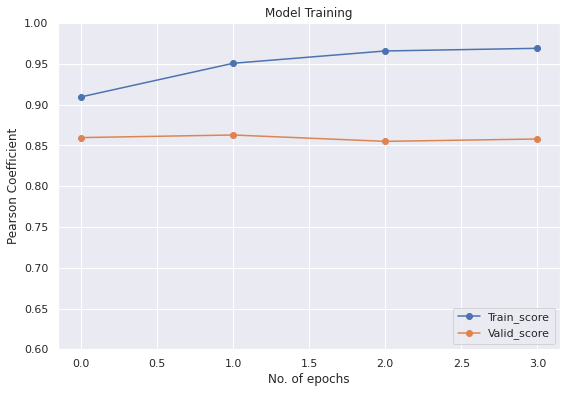

In [ ]:
#plot training and validation score
import matplotlib.pyplot as plt
import seaborn as sns
train_score = epochs_score['train_Pearson_score'] # train_score
valid_score = epochs_score['val_Pearson_score'] # valid_score
 

sns.set(style='darkgrid') #set plot style
sns.set(rc={'figure.figsize':(9,6)}) # set figure size
plt.plot(train_score ,'-o', label= 'Train_score' )#plot train score
plt.plot(valid_score, '-o', label='Valid_score') # plot valid score
plt.title('Model Training') #  title
plt.ylabel('Pearson Coefficient') # ylabel
plt.xlabel('No. of epochs') # xlabel
plt.ylim([0.6,1]) #set the ylabel limit
plt.legend(loc=4) #label 
plt.show()





In [ ]:
epochs_score

defaultdict(list,
            {'train_Pearson_score': [0.9095253426930726,
              0.9507620315805678,
              0.9658815727894156,
              0.969138802258031],
             'train_loss': [0.014850491575068897,
              0.008308044855948538,
              0.005935145596029341,
              0.005526766769859629],
             'val_Pearson_score': [0.8596345902946204,
              0.8628200338581528,
              0.8550283151967495,
              0.8579226058427706],
             'val_loss': [0.029453454192410758,
              0.028082741582964327,
              0.028189612146308447,
              0.0281864658315131]})

# Evaluate on test

In [ ]:
#evaluate on test data
test_loss, test_Pearson_score = model_eval(
                                      custom_model, 
                                      test_data_loader, 
                                      device, 
                                      loss_fn)

In [ ]:
print(test_loss, test_Pearson_score)

0.030865792506213845 0.8435864555838117


In [ ]:
#evaluate on test data
test_loss, test_Pearson_score = model_eval(
                                      custom_model, 
                                      test_data_loader, 
                                      device, 
                                      loss_fn)

In [ ]:
print(test_loss, test_Pearson_score)

0.19161386008577785 0.47228528910939277


# Save and Load model

In [ ]:
#save model
torch.save(custom_model.state_dict(), 'fine_tuned_model_state.bin')

In [ ]:
#load model and evaluate on test data
fine_tuned_model = SentenceSimilarityModel()
fine_tuned_model.load_state_dict(torch.load('/content/best_model.bin'))
test_loss, test_Pearson_score = model_eval(
                                      fine_tuned_model.to(device),
                                      test_data_loader, 
                                      device, 
                                      loss_fn)
print(test_loss, test_Pearson_score)

0.03092721268406202 0.8363047344782726


In [ ]:
#clear unused GPU
with torch.cuda.device('cuda:0'):
   torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Tue Jun 30 13:41:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    58W / 149W |   2651MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------